In [252]:
import pandas as pd
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import datetime
import time

df = pd.read_csv ('soil_moisture_data/2023_ru_soil_moisture.csv')
df['time'] = pd.to_datetime(df['time'])  # Convert timestamp to datetime if it's not already
# Create a new column for the date*
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])

# sensor locations
sensor_loc_gdf = gpd.read_file('soil_moisture_data/ru_sensor_locations.geojson')

# for export to ISMN swich the two
df = df.drop(columns=['time'])
#df['time'] = df['time'].dt.tz_localize(None)
print('rows count:',len(df))
df.head()

rows count: 164499


,device_id,soil_ec,soil_temp,soil_mc,lat,long,date
0,ru-lse-01,308,20.51,28.81,53.869439,12.085827,2023-06-25
1,ru-lse-01,309,20.57,28.83,53.869439,12.085827,2023-06-25
2,ru-lse-01,308,20.63,28.83,53.869439,12.085827,2023-06-25
3,ru-lse-01,308,20.72,28.84,53.869439,12.085827,2023-06-25
4,ru-lse-01,309,20.82,28.85,53.869439,12.085827,2023-06-25


In [239]:
fc = pd.read_csv ('soil_properties_data/2023_ru_sensors_fc_pwp.csv')
fc = fc.rename(columns={'FC [vol-%]':'FC', 'PWP [vol-%]':'PWP'})
fc.head()

,device_id,FC,PWP
0,ru-lse-01,37.46,12.59
1,ru-lse-02,31.10,8.01
2,ru-lse-03,33.29,9.50
3,ru-lse-04,30.85,8.00
4,ru-lse-05,31.42,8.21


In [240]:
#soil_scanning = pd.read_csv('soil_data_MZ/soil_scanning_kassow.csv')
#MZ = soil_scanning.groupby('MZ_irr')[['TOC','MC','Clay','TWI','NDVI']].mean().reset_index()
#MZ = MZ.round({'TOC':2,'MC':2,'Clay':2,'TWI':2,'NDVI':2})
#MZ

In [251]:
soil_scanning_gdf = gpd.read_file('soil_properties_data/soil_scanning_kassow.geojson')
old_crs = soil_scanning_gdf.crs.to_epsg()
soil_scanning_gdf = soil_scanning_gdf.to_crs(4326)
new_crs = soil_scanning_gdf.crs.to_epsg()
print("Transform crs of soil_scanning_kassow.geojson from",old_crs,"to",new_crs)
print('rows count:',len(df))
soil_scanning_gdf.head()

Transform crs of soil_scanning_kassow.geojson from 32633 to 4326
rows count: 164499


,TOC,MC,Clay,TWI,pH,P,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility,geometry
0,1.02,8.45,8.94,8.91,6.71,15.49,14.51,14.61,9.23,0.49,0.247749,0.332385,0.185871,4,2,H,POINT (12.07532 53.86818)
1,1.06,8.19,8.88,8.89,6.70,16.00,14.72,14.51,9.35,0.47,0.197589,0.455102,0.240561,4,2,H,POINT (12.07540 53.86818)
2,1.07,8.45,8.64,9.04,6.72,16.09,13.75,14.12,9.95,0.46,0.197589,0.302123,0.175448,4,2,H,POINT (12.07548 53.86818)
3,1.09,8.15,8.87,8.59,6.70,16.06,14.64,14.59,9.36,0.47,0.247749,0.392780,0.232225,4,2,H,POINT (12.07524 53.86814)
4,1.08,8.16,8.79,8.62,6.69,16.04,14.74,14.68,9.24,0.46,0.247749,0.349937,0.212110,4,2,H,POINT (12.07532 53.86813)


In [242]:
# Join sensor locations with nearest soil scanning data and turn it into a normal dataframe
sensor_gdf = gpd.sjoin_nearest(sensor_loc_gdf, soil_scanning_gdf)
sensor = pd.DataFrame(sensor_gdf)
sensor = pd.DataFrame(sensor.drop(columns='geometry'))
sensor.head()

e:\conda\envs\analysis\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,device_id,index_right,TOC,MC,Clay,TWI,pH,P,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility
0,ru-lse-01,2981,1.03,9.65,8.83,5.66,7.04,11.15,17.73,19.43,9.83,0.18,0.487488,0.897306,0.453549,5,6,ML
1,ru-lse-02,1309,1.20,8.69,5.03,7.97,6.68,18.84,14.96,16.10,12.13,0.23,0.609393,0.915297,0.440586,7,7,H
2,ru-lse-03,1150,1.05,8.66,8.02,6.35,6.98,14.21,16.99,16.11,8.90,0.19,0.576737,0.916857,0.426831,8,8,MH
3,ru-lse-04,1344,0.92,7.95,8.01,7.77,6.23,13.34,13.45,12.05,8.73,0.21,0.566124,0.921316,0.447075,6,5,L
4,ru-lse-05,142,1.06,8.75,8.70,7.29,6.47,13.37,14.32,13.28,9.05,0.45,0.311084,0.878740,0.403959,2,1,ML


In [243]:
# weather
weather = pd.read_csv('klimadaten/DWD_2023.csv')
weather['date'] = pd.to_datetime(weather['date'])
weather

,date,temp,wind_m_s,humidity,sun_hours,prcp_mm
0,2023-06-05,16.1,1.6,60.50,15.5,0.0
1,2023-06-06,17.3,1.7,60.13,15.1,0.0
2,2023-06-07,17.8,1.5,64.96,15.1,0.0
3,2023-06-08,18.1,1.8,63.38,14.5,0.0
4,2023-06-09,17.0,2.3,67.79,15.6,0.0
...,...,...,...,...,...,...
99,2023-09-12,18.4,1.2,92.13,2.3,6.6
100,2023-09-13,15.6,1.8,94.75,0.0,22.6
101,2023-09-14,13.2,1.2,84.21,9.8,0.0
102,2023-09-15,14.8,1.6,78.50,11.5,0.0


In [244]:
yield_potato = pd.read_csv('yield/kassow_potato_yield_2023.csv')
yield_potato = yield_potato.drop(columns=['tubers','plants'])
yield_potato = yield_potato.rename(columns={'yield_kg':'yield'})

yield_potato.head()

,device_id,yield,variety
0,ru-lse-05,2.46,HAP
1,ru-lse-06,1.58,HAP
2,ru-lse-07,3.48,HAP
3,ru-lse-08,3.40,HAP
4,ru-lse-09,2.18,HAP


In [245]:
# kassow_1: Südosten. Sensoren: 5, 6, 7, 8, 9, 10, 11, 12, 13
# kassow_2: Mitte. Sensor: 30
# kassow_3: Norden. Sensoren: 1,2,3,4,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29

# data range: 2023-06-05 2023-09-16

# Kassow_1 Bewässerung:        2023-06-26       | 2023-07-12 - 2023-07-13
# Kassow_3 Bewässerung: 2023-06-20 - 2023-06-24 |

In [249]:
df = df.merge(yield_potato, on='device_id', how='left')
df = df.merge(fc, on='device_id', how='left')

# Calculate the Available Water Content (nutzbare Feldkapazität) [Vol-%]
# https://www.dwd.de/DE/fachnutzer/landwirtschaft/dokumentationen/allgemein/bf_erlaeuterungen.pdf?__blob=publicationFile&v=7
df["AW"] = (df["soil_mc"]-df["PWP"])/(df["FC"]-df["PWP"])*100
df = df.round({'FC':1,'PWP':1,'AW':1})

df = df.merge(weather, on='date', how='left')
#df = df.merge(MZ, on='MZ_irr', how='left')
df = df.merge(sensor, on='device_id', how='left')
df.head()

,device_id,soil_ec,soil_temp,soil_mc,lat,long,date,yield,variety,FC,...,K,Mg,CEC,NDVI_S2_22,NDVI_S2_23,NDVI_UAV_23,NDRE_UAV_23,MZ_irr,MZ_fer,fertility
0,ru-lse-01,308,20.51,28.81,53.869439,12.085827,2023-06-25,NaN,NaN,37.5,...,17.73,19.43,9.83,0.18,0.487488,0.897306,0.453549,5,6,ML
1,ru-lse-01,309,20.57,28.83,53.869439,12.085827,2023-06-25,NaN,NaN,37.5,...,17.73,19.43,9.83,0.18,0.487488,0.897306,0.453549,5,6,ML
2,ru-lse-01,308,20.63,28.83,53.869439,12.085827,2023-06-25,NaN,NaN,37.5,...,17.73,19.43,9.83,0.18,0.487488,0.897306,0.453549,5,6,ML
3,ru-lse-01,308,20.72,28.84,53.869439,12.085827,2023-06-25,NaN,NaN,37.5,...,17.73,19.43,9.83,0.18,0.487488,0.897306,0.453549,5,6,ML
4,ru-lse-01,309,20.82,28.85,53.869439,12.085827,2023-06-25,NaN,NaN,37.5,...,17.73,19.43,9.83,0.18,0.487488,0.897306,0.453549,5,6,ML


In [235]:
# Set ru-lse-15 to NaN for the time it was not sending
condition = (df['date'] >= '2023-06-27') & (df['date'] <= '2023-08-02') & (df["device_id"] == "ru-lse-15")
df.loc[condition, ['soil_mc','AW']] = None  
kassow_15 = (df.loc[df['device_id'].isin(['ru-lse-15'])])

kassow_1 = (df.loc[df['device_id'].isin(['ru-lse-05','ru-lse-12','ru-lse-07','ru-lse-08',
                                         'ru-lse-09','ru-lse-10','ru-lse-11','ru-lse-12','ru-lse-13'])])
kassow_2 = (df.loc[df['device_id'].isin(['ru-lse-30'])])
kassow_3_25 = (df.loc[df['device_id'].isin(['ru-lse-14','ru-lse-15','ru-lse-16','ru-lse-17','ru-lse-18',
                                         'ru-lse-19','ru-lse-20','ru-lse-21','ru-lse-22','ru-lse-23',
                                         'ru-lse-24','ru-lse-25','ru-lse-26','ru-lse-27','ru-lse-28','ru-lse-29'])])
kassow_50 = (df.loc[df['device_id'].isin(['ru-lse-01','ru-lse-02','ru-lse-03','ru-lse-04'])])

kassow_25_mean_per_day = kassow_25.groupby('date')[['soil_mc','AW']].mean().reset_index()
kassow_25_mean_per_day = kassow_25_mean_per_day.rename(columns={'soil_mc':'soil_mc_mean_25','AW':'AW_mean_25'})

kassow_50_mean_per_day = kassow_50.groupby('date')[['soil_mc','AW']].mean().reset_index()
kassow_50_mean_per_day = kassow_50_mean_per_day.rename(columns={'soil_mc':'soil_mc_mean_50','AW':'AW_mean_50'})

mean_per_day = kassow_25_mean_per_day.copy()
mean_per_day = mean_per_day.merge(kassow_50_mean_per_day, left_on='date', right_on='date')
mean_per_day['soil_mc_mean'] = (mean_per_day['soil_mc_mean_25'] + mean_per_day['soil_mc_mean_50'])/2
mean_per_day['AW_mean'] = (mean_per_day['AW_mean_25'] + mean_per_day['AW_mean_50'])/2

kassow_1_mz1 = (df.loc[df['device_id'].isin(['ru-lse-07','ru-lse-09'])])
kassow_1_mz2 = (df.loc[df['device_id'].isin(['ru-lse-05','ru-lse-12'])])
kassow_1_mz3 = (df.loc[df['device_id'].isin(['ru-lse-06','ru-lse-10','ru-lse-11'])])
kassow_1_mz4 = (df.loc[df['device_id'].isin(['ru-lse-08','ru-lse-13'])])

kassow_3_mz1 = (df.loc[df['device_id'].isin(['ru-lse-15','ru-lse-18','ru-lse-19','ru-lse-24'])])
kassow_3_mz2 = (df.loc[df['device_id'].isin(['ru-lse-28','ru-lse-29'])])
kassow_3_mz3 = (df.loc[df['device_id'].isin(['ru-lse-16','ru-lse-21','ru-lse-22','ru-lse-27'])])
kassow_3_mz4 = (df.loc[df['device_id'].isin(['ru-lse-14','ru-lse-17','ru-lse-20','ru-lse-23','ru-lse-25','ru-lse-26'])])
       
palette_1    = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
palette_3    = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252']
palette_30 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5','#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5','#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173','#5254a3', '#5e5e5e', '#636363', '#6b6b6b']
kassow_25 = pd.concat([kassow_3_25, kassow_1])
kassow_25_noirr = (df.loc[df['device_id'].isin(['ru-lse-11','ru-lse-16','ru-lse-17','ru-lse-18','ru-lse-20','ru-lse-21','ru-lse-23'])])


In [59]:
#sensor_infos = df.groupby(['device_id','lat','long'])[['soil_mc']].mean().reset_index()
#sensor_infos.to_csv('output_files/sensor_informations.csv', index=False)
#sensor_infos

In [14]:
#export = df[['device_id','time', 'soil_mc', 'soil_temp']]
#export = export.rename(columns={'soil_mc':'sm_25','soil_temp':'ts_25'})
#names = df.device_id.unique()
#export = export.sort_values(by=['time'])
#for i in names:
#    export[['time','sm_25','ts_25']].loc[export['device_id'].isin([i])].to_csv('export/for_ISMN/'+i+'.csv', index=False)

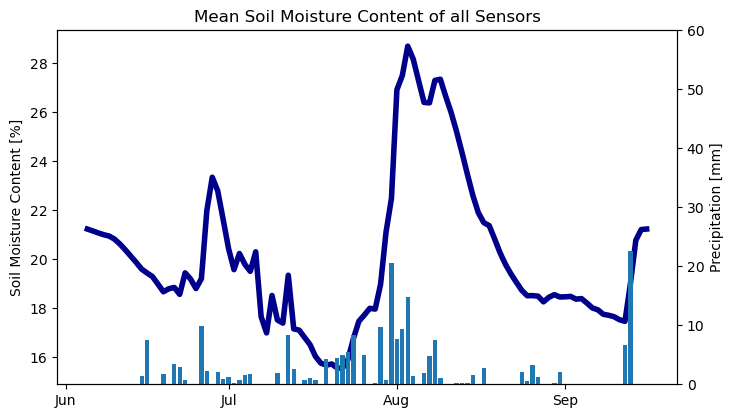

In [236]:
## Medan soil moisture for all Sensors per day
# Group by date and calculate median for each group
mean_per_day = df.groupby(['date','prcp_mm','temp'])[['soil_mc','soil_temp']].mean().reset_index()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(mean_per_day['date'], mean_per_day['soil_mc'], linewidth=4, color='darkblue')
ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('Mean Soil Moisture Content of all Sensors')
ax1.set_ylabel('Soil Moisture Content [%]')
ax2.set_ylabel('Precipitation [mm]')
ax2.set_ylim([0, 60])

## Set months for x-axis ticks
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)  # Specify formatter

plt.savefig('plots/Mean Soil Moisture Content of all Sensors.png', bbox_inches='tight')
mean_per_day.to_csv('export/Daily_soil_moisture.csv', sep=',', index=False)

plt.show()

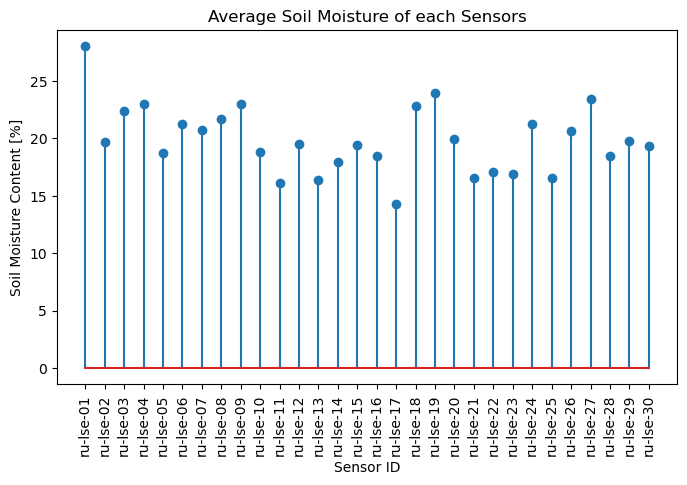

In [234]:
## Average soil moisture of each soil moisture sensor
average_per_year = df.groupby('device_id')[['soil_mc','AW']].mean().reset_index()

plt.stem(average_per_year['device_id'], average_per_year['soil_mc'])

plt.xlabel('Sensor ID')
plt.ylabel('Soil Moisture Content [%]')
plt.title('Average Soil Moisture of each Sensors')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.savefig('plots/Average Soil Moisture of each Sensors.png', bbox_inches='tight')
plt.show()

average_per_year.to_csv('export/mean_soil_moisture_AW_per_Sensor.csv', sep=',', index=False)

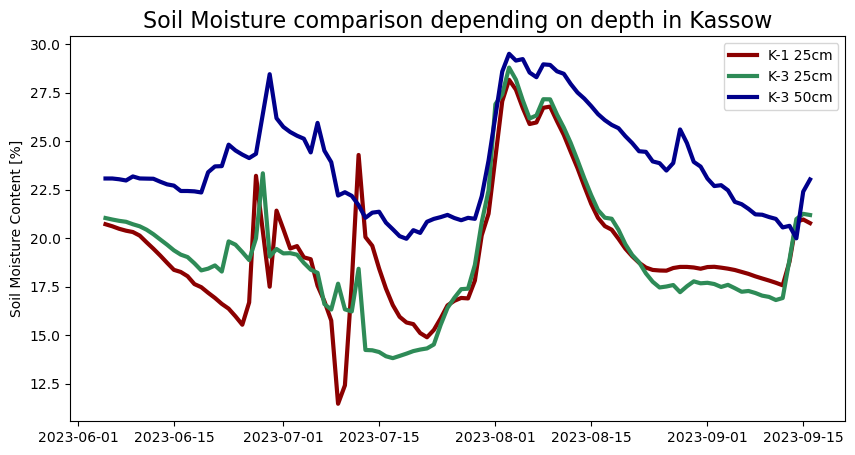

In [129]:
## Mean soil moisture per Depth
# Group by date and calculate mean for each group
plt.rcParams["figure.figsize"] = (10,5)

kassow_1_mean_per_day    = kassow_1.groupby('date')['soil_mc'].mean().reset_index()
kassow_3_25_mean_per_day = kassow_3_25.groupby('date')['soil_mc'].mean().reset_index()
kassow_50_mean_per_day = kassow_50.groupby('date')['soil_mc'].mean().reset_index()


plt.plot(kassow_1_mean_per_day['date'], kassow_1_mean_per_day['soil_mc'], label='K-1 25cm', linewidth=3, color = 'darkred')
plt.plot(kassow_3_25_mean_per_day['date'], kassow_3_25_mean_per_day['soil_mc'], label='K-3 25cm', linewidth=3, color = 'seagreen')
plt.plot(kassow_50_mean_per_day['date'], kassow_50_mean_per_day['soil_mc'], label='K-3 50cm', linewidth=3, color='darkblue')
plt.legend()
plt.ylabel('Soil Moisture Content [%]')
plt.title('Soil Moisture comparison depending on depth in Kassow', size=16)

plt.savefig('plots/Soil Moisture comparison depending on depth.png', bbox_inches='tight', dpi=600)
plt.show()

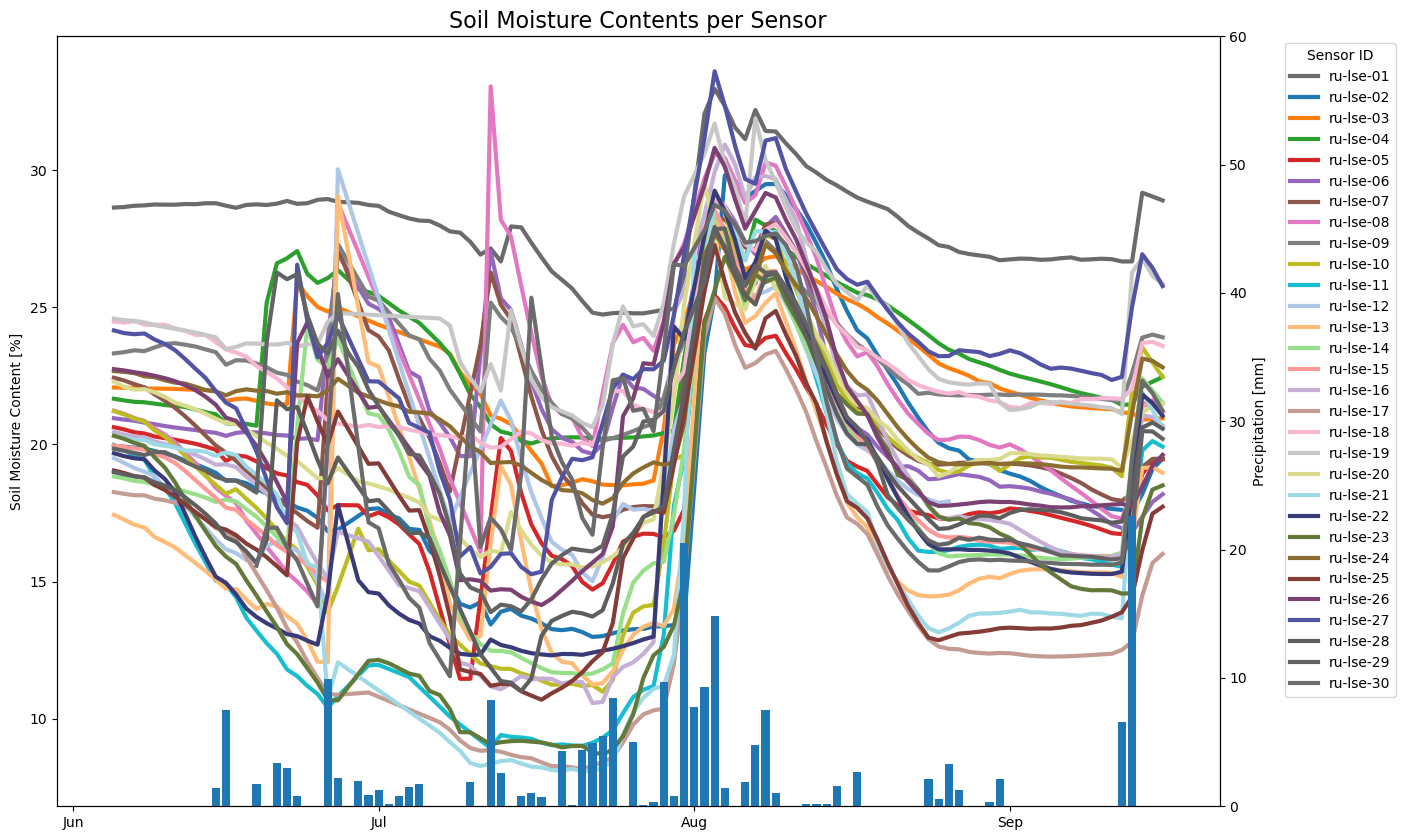

In [15]:
## Soil Moisture Contents per Sensor
kassow    = df.groupby(['device_id','date']).agg({'soil_mc':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','soil_mc', 'std']

#print(kassow)
plt.rcParams["figure.figsize"] = (15,10)
# Convert 'date' to datetime if it's not already
kassow['date'] = pd.to_datetime(kassow['date'])

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot each group separately with different colors
for i, (name, group) in enumerate(grouped_data):
    ax1.plot(group['date'], group['soil_mc'], label=name, linewidth=3, color=palette_30[i-1])

ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('Soil Moisture Contents per Sensor',size=16)
ax1.set_ylabel('Soil Moisture Content [%]')
ax2.set_ylabel('Precipitation [mm]')
ax1.legend(title='Sensor ID',ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_ylim([0, 60])

## Set months for x-axis ticks
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Soil Moisture Contents per Sensor.png', bbox_inches='tight', dpi=600)
plt.show()

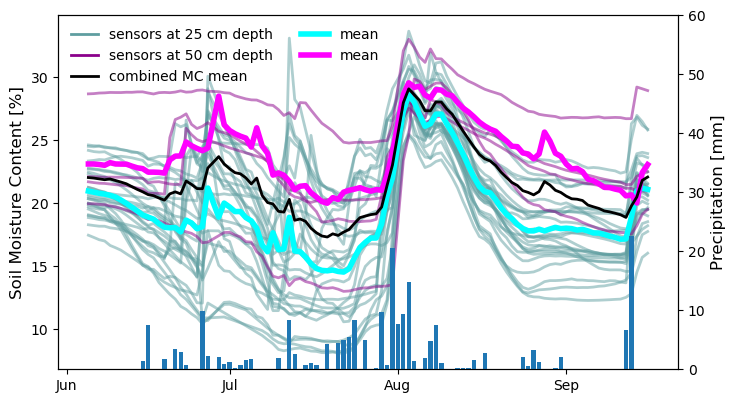

In [229]:
## Soil Moisture Contents per Sensor2
kassow    = df.groupby(['device_id','date']).agg({'soil_mc':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','soil_mc', 'std']

#print(kassow)
plt.rcParams["figure.figsize"] = (8,4.6)
# Convert 'date' to datetime if it's not already
kassow['date'] = pd.to_datetime(kassow['date'])

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
custom_legend_handles = []

# Plot each group separately with different colors

for i, (name, group) in enumerate(grouped_data):
        if name != 'ru-lse-01' and name != 'ru-lse-02' and name != 'ru-lse-03' and name != 'ru-lse-04':
            line = ax1.plot(group['date'], group['soil_mc'], label='25 cm', linewidth=2, color='cadetblue', alpha=0.5)

for i, (name, group) in enumerate(grouped_data):
    if name == 'ru-lse-01' or name == 'ru-lse-02' or name == 'ru-lse-03' or name == 'ru-lse-04':
        line = ax1.plot(group['date'], group['soil_mc'], label='50 cm', linewidth=2, color='darkmagenta', alpha=0.5)

ax1.plot(mean_per_day['date'], mean_per_day['soil_mc_mean_25'], linewidth=4, color='aqua')
ax1.plot(mean_per_day['date'], mean_per_day['soil_mc_mean_50'], linewidth=4, color='magenta')
ax1.plot(mean_per_day['date'], mean_per_day['soil_mc_mean'], linewidth=2, color='black')


ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('',size=16)
ax1.set_ylabel('Soil Moisture Content [%]',fontsize=12)
ax2.set_ylabel('Precipitation [mm]',fontsize=12)
ax2.set_ylim([0, 60])

handles, labels = ax1.get_legend_handles_labels()
unique_labels = ['sensors at 25 cm depth', 'sensors at 50 cm depth','combined MC mean','mean','mean']
proxy_artists = [plt.Line2D([0], [0], linestyle='-', linewidth=2, color='cadetblue'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=2, color='darkmagenta'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=2, color='black'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=4, color='aqua'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=4, color='magenta')]
ax1.legend(proxy_artists, unique_labels, title='', ncol=2, bbox_to_anchor=(0.0, 1), loc='upper left',frameon=False)

## Set months for x-axis ticks
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Soil Moisture Contents per Sensor2.png', bbox_inches='tight', dpi=300)
plt.show()

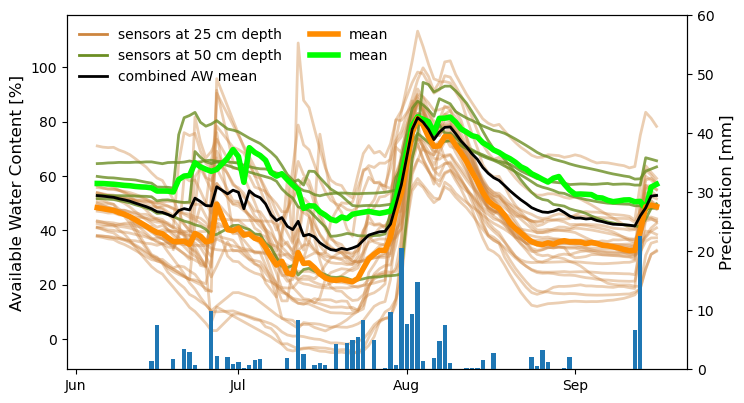

In [233]:
## Available Water Contents per Sensor
kassow    = df.groupby(['device_id','date']).agg({'AW':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','AW', 'std']

#print(kassow)
plt.rcParams["figure.figsize"] = (8,4.6)
# Convert 'date' to datetime if it's not already
kassow['date'] = pd.to_datetime(kassow['date'])

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
custom_legend_handles = []

# Plot each group separately with different colors

for i, (name, group) in enumerate(grouped_data):
        if name != 'ru-lse-01' and name != 'ru-lse-02' and name != 'ru-lse-03' and name != 'ru-lse-04':
            line = ax1.plot(group['date'], group['AW'], label='25 cm', linewidth=2, color='peru', alpha=0.4)

for i, (name, group) in enumerate(grouped_data):
    if name == 'ru-lse-01' or name == 'ru-lse-02' or name == 'ru-lse-03' or name == 'ru-lse-04':
        line = ax1.plot(group['date'], group['AW'], label='50 cm', linewidth=2, color='olivedrab', alpha=0.8)


ax1.plot(mean_per_day['date'], mean_per_day['AW_mean_50'], linewidth=4, color='lime')
ax1.plot(mean_per_day['date'], mean_per_day['AW_mean_25'], linewidth=4, color='darkorange')
ax1.plot(mean_per_day['date'], mean_per_day['AW_mean'], linewidth=2, color='black')

ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('',size=16)
ax1.set_ylabel('Available Water Content [%]',fontsize=12)
ax2.set_ylabel('Precipitation [mm]',fontsize=12)
ax2.set_ylim([0, 60])

handles, labels = ax1.get_legend_handles_labels()
unique_labels = ['sensors at 25 cm depth','sensors at 50 cm depth', 'combined AW mean', 'mean', 'mean']
proxy_artists = [plt.Line2D([0], [0], linestyle='-', linewidth=2, color='peru'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=2, color='olivedrab'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=2, color='black'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=4, color='darkorange'),
                 plt.Line2D([0], [0], linestyle='-', linewidth=4, color='lime')]
ax1.legend(proxy_artists, unique_labels, title='', ncol=2, bbox_to_anchor=(0.0, 1), loc='upper left', frameon=False)

## Set months for x-axis ticks
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Available Water Contents per Sensor.png', bbox_inches='tight', dpi=300)
plt.show()

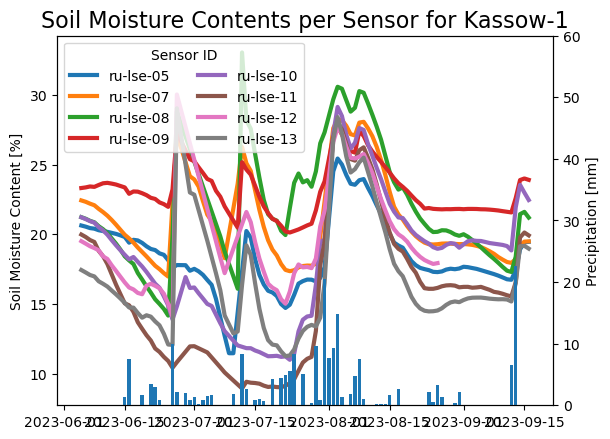

In [65]:
## Soil Moisture Contents per Sensor for Kassow-1
kassow    = kassow_1.groupby(['device_id','date']).agg({'soil_mc':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','soil_mc', 'std']

#print(kassow)
#plt.rcParams["figure.figsize"] = (15,10)
# Convert 'date' to datetime if it's not already
kassow['date'] = pd.to_datetime(kassow['date'])

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

# Plot each group separately with different colors
for i, (name, group) in enumerate(grouped_data):
    ax1.plot(group['date'], group['soil_mc'], label=name, linewidth=3, color=palette_1[i])

ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('Soil Moisture Contents per Sensor for Kassow-1',size=16)
ax1.set_ylabel('Soil Moisture Content [%]')
ax2.set_ylabel('Precipitation [mm]')
ax1.legend(title='Sensor ID',ncol=2)
ax2.set_ylim([0, 60])

## Set months for x-axis ticks
#locator = mdates.MonthLocator()  # every month
#fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
#X = plt.gca().xaxis
#X.set_major_locator(locator)
#X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Soil Moisture Contents per Sensor for Kassow-1.png', bbox_inches='tight', dpi=600)
plt.show()

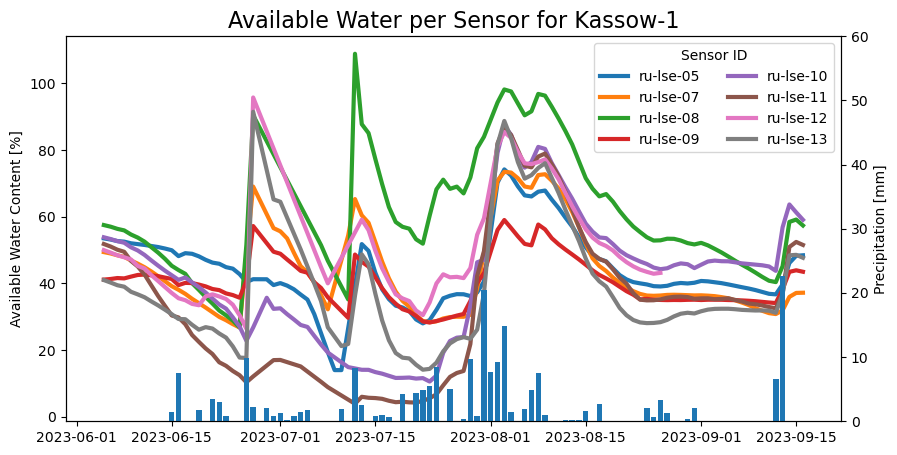

In [68]:
## Available Water per Sensor for Kassow-1
kassow    = kassow_1.groupby(['device_id','date']).agg({'AW':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','AW', 'std']

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')



fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

for i, (name, group) in enumerate(grouped_data):
    ax1.plot(group['date'], group['AW'], label=name, linewidth=3, color=palette_1[i])

ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('Available Water per Sensor for Kassow-1',size=16)
ax1.set_ylabel('Available Water Content [%]')
ax2.set_ylabel('Precipitation [mm]')
ax1.legend(title='Sensor ID',ncol=2)

#ax1.tick_params(rotation=45)

ax2.set_ylim([0, 60])

## Set months for x-axis ticks
#locator = mdates.MonthLocator()  # every month
#fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
#X = plt.gca().xaxis
#X.set_major_locator(locator)
#X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Available Water per Sensor for Kassow-1.png', bbox_inches='tight', dpi=600)
plt.show()

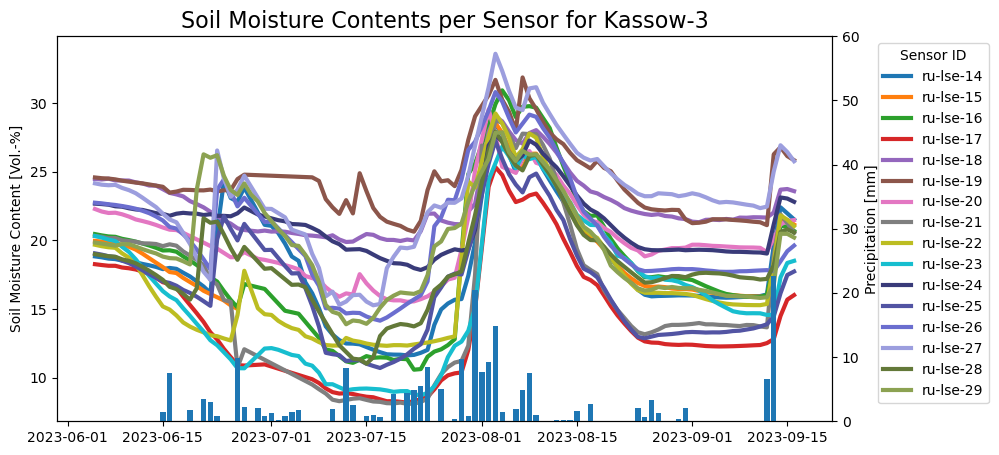

In [69]:
## Group by 'device_id'
#kassow_3_25 = (df.loc[df['device_id'].isin(['ru-lse-14','ru-lse-15'])])
kassow    = kassow_3_25.groupby(['device_id','date']).agg({'soil_mc':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','soil_mc', 'std']

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')

#plt.rcParams["figure.figsize"] = (15,5)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
# Plot each group separately with different colors
for i, (name, group) in enumerate(grouped_data):
    ax1.plot(group['date'], group['soil_mc'], label=name, linewidth=3, color=palette_3[i])

ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('Soil Moisture Contents per Sensor for Kassow-3',size=16)
ax1.set_ylabel('Soil Moisture Content [Vol.-%]')
ax2.set_ylabel('Precipitation [mm]')
ax1.legend(title='Sensor ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend outside the plot
#ax1.tick_params(rotation=45)

ax2.set_ylim([0, 60])

## Set months for x-axis ticks
#locator = mdates.MonthLocator()  # every month
#fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
#X = plt.gca().xaxis
#X.set_major_locator(locator)
#.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Soil Moisture Contents per Sensor for Kassow-3.png', bbox_inches='tight', dpi=600)
plt.show()

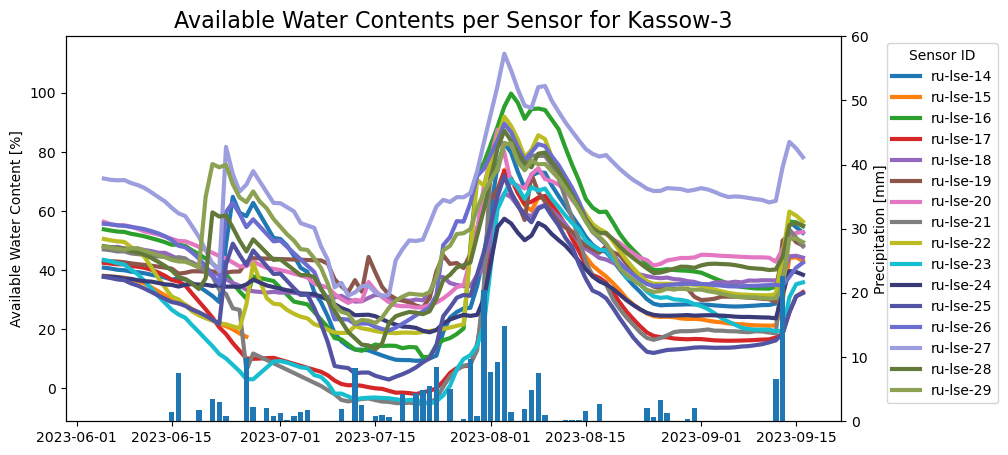

In [70]:
## Group by 'device_id'

kassow    = kassow_3_25.groupby(['device_id','date']).agg({'AW':['mean','std']}).reset_index()
kassow.columns = ['device_id','date','AW', 'std']

# Group by 'device_id'
grouped_data = kassow.groupby('device_id')

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

# Define a list of custom colors

# Plot each group separately with different colors
for i, (name, group) in enumerate(grouped_data):
    ax1.plot(group['date'], group['AW'], label=name, linewidth=3, color=palette_3[i % len(palette_3)])
    
ax2.bar(weather['date'],weather['prcp_mm'])

plt.title('Available Water Contents per Sensor for Kassow-3',size=16)
ax1.set_ylabel('Available Water Content [%]')
ax2.set_ylabel('Precipitation [mm]')
ax1.legend(title='Sensor ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend outside the plot
#ax1.tick_params(rotation=45)

ax2.set_ylim([0, 60])

## Set months for x-axis ticks
#locator = mdates.MonthLocator()  # every month
#fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
#X = plt.gca().xaxis
#X.set_major_locator(locator)
#X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Available Water Contents per Sensor for Kassow-3.png', bbox_inches='tight')
plt.show()

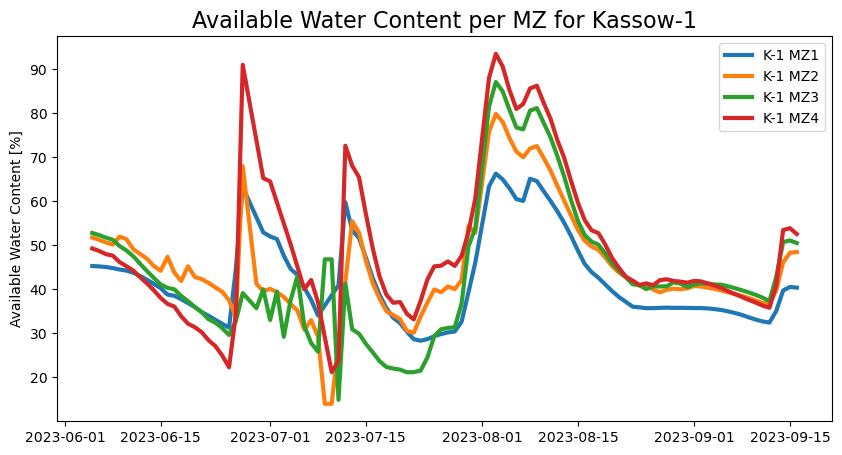

In [71]:
## Mean soil moisture per day and per MZ
# Group by date and calculate median for each group

kassow_1_mz1_mean_per_day    = kassow_1_mz1.groupby('date')['AW'].mean().reset_index()
kassow_1_mz2_mean_per_day    = kassow_1_mz2.groupby('date')['AW'].mean().reset_index()
kassow_1_mz3_mean_per_day    = kassow_1_mz3.groupby('date')['AW'].mean().reset_index()
kassow_1_mz4_mean_per_day    = kassow_1_mz4.groupby('date')['AW'].mean().reset_index()

plt.plot(kassow_1_mz1_mean_per_day['date'], kassow_1_mz1_mean_per_day['AW'], label='K-1 MZ1', linewidth=3)
plt.plot(kassow_1_mz2_mean_per_day['date'], kassow_1_mz2_mean_per_day['AW'], label='K-1 MZ2', linewidth=3)
plt.plot(kassow_1_mz3_mean_per_day['date'], kassow_1_mz3_mean_per_day['AW'], label='K-1 MZ3', linewidth=3)
plt.plot(kassow_1_mz4_mean_per_day['date'], kassow_1_mz4_mean_per_day['AW'], label='K-1 MZ4', linewidth=3)

plt.legend()
plt.ylabel('Available Water Content [%]')
plt.title('Available Water Content per MZ for Kassow-1',size=16)

## Set months for x-axis ticks
#locator = mdates.MonthLocator()  # every month
#fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
#X = plt.gca().xaxis
#X.set_major_locator(locator)
#X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Available Water Content per Managment Zone in Kassow-1.png', bbox_inches='tight', dpi=600)
plt.show()

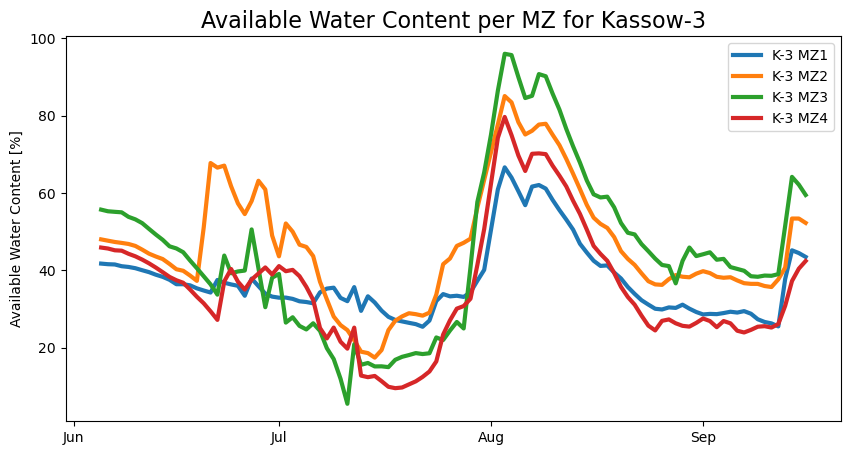

In [72]:
## Mean soil moisture per day and per MZ
# Group by date and calculate median for each group

kassow_3_mz1_mean_per_day    = kassow_3_mz1.groupby('date')['AW'].mean().reset_index()
kassow_3_mz2_mean_per_day    = kassow_3_mz2.groupby('date')['AW'].mean().reset_index()
kassow_3_mz3_mean_per_day    = kassow_3_mz3.groupby('date')['AW'].mean().reset_index()
kassow_3_mz4_mean_per_day    = kassow_3_mz4.groupby('date')['AW'].mean().reset_index()
kassow_3_mz4_mean_per_day    = kassow_3_mz4.groupby('date')['AW'].mean().reset_index()

plt.plot(kassow_3_mz1_mean_per_day['date'], kassow_3_mz1_mean_per_day['AW'], label='K-3 MZ1', linewidth=3)
plt.plot(kassow_3_mz2_mean_per_day['date'], kassow_3_mz2_mean_per_day['AW'], label='K-3 MZ2', linewidth=3)
plt.plot(kassow_3_mz3_mean_per_day['date'], kassow_3_mz3_mean_per_day['AW'], label='K-3 MZ3', linewidth=3)
plt.plot(kassow_3_mz4_mean_per_day['date'], kassow_3_mz4_mean_per_day['AW'], label='K-3 MZ4', linewidth=3)

plt.legend()
plt.ylabel('Available Water Content [%]')
plt.title('Available Water Content per MZ for Kassow-3',size=16)

## Set months for x-axis ticks
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b') # Specify the format - %b gives us Jan, Feb...
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)       # Specify formatter

plt.savefig('plots/Available Water Content per Managment Zone in Kassow-3.png', bbox_inches='tight')
plt.show()

In [ ]:
# Evapotranspiration



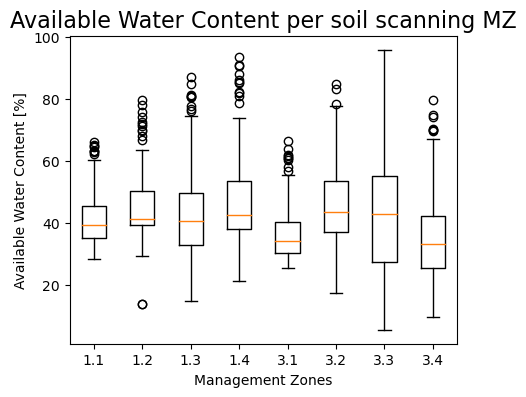

In [80]:
## Mean soil moisture per day and per MZ
# Group by date and calculate median for each group

plt.rcParams["figure.figsize"] = (5,4)

kassow_1_mz1_mean_per_day    = kassow_1_mz1.groupby('date')['AW'].mean().reset_index()
kassow_1_mz2_mean_per_day    = kassow_1_mz2.groupby('date')['AW'].mean().reset_index()
kassow_1_mz3_mean_per_day    = kassow_1_mz3.groupby('date')['AW'].mean().reset_index()
kassow_1_mz4_mean_per_day    = kassow_1_mz4.groupby('date')['AW'].mean().reset_index()
kassow_3_mz1_mean_per_day    = kassow_3_mz1.groupby('date')['AW'].mean().reset_index()
kassow_3_mz2_mean_per_day    = kassow_3_mz2.groupby('date')['AW'].mean().reset_index()
kassow_3_mz3_mean_per_day    = kassow_3_mz3.groupby('date')['AW'].mean().reset_index()
kassow_3_mz4_mean_per_day    = kassow_3_mz4.groupby('date')['AW'].mean().reset_index()


kassow_boxplot = [kassow_1_mz1_mean_per_day['AW'],
                  kassow_1_mz2_mean_per_day['AW'],
                  kassow_1_mz3_mean_per_day['AW'],
                  kassow_1_mz4_mean_per_day['AW'],
                  kassow_3_mz1_mean_per_day['AW'],
                  kassow_3_mz2_mean_per_day['AW'],
                  kassow_3_mz3_mean_per_day['AW'],
                  kassow_3_mz4_mean_per_day['AW']]

#plt.figure(figsize=(3,4.8)) # Defaut is: (6.4 , 4.8) (in inches)
plt.boxplot(kassow_boxplot)

plt.xticks([1,2,3,4,5,6,7,8], ['1.1','1.2','1.3','1.4','3.1','3.2','3.3','3.4'])

plt.ylabel('Available Water Content [%]')
plt.xlabel('Management Zones')
plt.title('Available Water Content per soil scanning MZ',size=16)


plt.savefig('plots/Boxplot Available Water Content per soil scanning MZ.png', bbox_inches='tight', dpi=600)
plt.show()

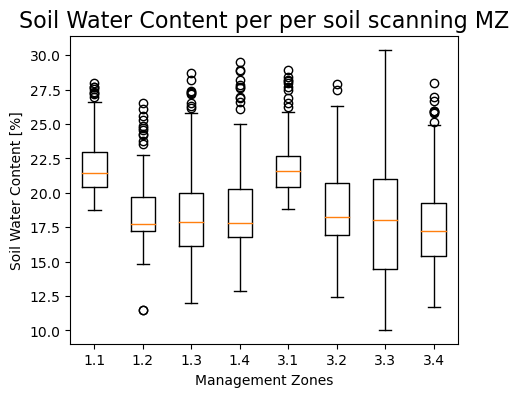

In [81]:
## Mean soil moisture per day and per MZ
# Group by date and calculate median for each group

plt.rcParams["figure.figsize"] = (5,4)

kassow_1_mz1_mean_per_day    = kassow_1_mz1.groupby('date')['soil_mc'].mean().reset_index()
kassow_1_mz2_mean_per_day    = kassow_1_mz2.groupby('date')['soil_mc'].mean().reset_index()
kassow_1_mz3_mean_per_day    = kassow_1_mz3.groupby('date')['soil_mc'].mean().reset_index()
kassow_1_mz4_mean_per_day    = kassow_1_mz4.groupby('date')['soil_mc'].mean().reset_index()
kassow_3_mz1_mean_per_day    = kassow_3_mz1.groupby('date')['soil_mc'].mean().reset_index()
kassow_3_mz2_mean_per_day    = kassow_3_mz2.groupby('date')['soil_mc'].mean().reset_index()
kassow_3_mz3_mean_per_day    = kassow_3_mz3.groupby('date')['soil_mc'].mean().reset_index()
kassow_3_mz4_mean_per_day    = kassow_3_mz4.groupby('date')['soil_mc'].mean().reset_index()


kassow_boxplot = [kassow_1_mz1_mean_per_day['soil_mc'],
                  kassow_1_mz2_mean_per_day['soil_mc'],
                  kassow_1_mz3_mean_per_day['soil_mc'],
                  kassow_1_mz4_mean_per_day['soil_mc'],
                  kassow_3_mz1_mean_per_day['soil_mc'],
                  kassow_3_mz2_mean_per_day['soil_mc'],
                  kassow_3_mz3_mean_per_day['soil_mc'],
                  kassow_3_mz4_mean_per_day['soil_mc']]

#plt.figure(figsize=(3,4.8)) # Defaut is: (6.4 , 4.8) (in inches)
plt.boxplot(kassow_boxplot)

plt.xticks([1,2,3,4,5,6,7,8], ['1.1','1.2','1.3','1.4','3.1','3.2','3.3','3.4'])

plt.ylabel('Soil Water Content [%]')
plt.xlabel('Management Zones')
plt.title('Soil Water Content per per soil scanning MZ',size=16)

plt.savefig('plots/Boxplot Soil Water Content per soil scanning MZ.png', bbox_inches='tight', dpi=600)
plt.show()

In [23]:
#kassow_3_25_AUTH = kassow_3_25
#condition = (kassow_3_25_AUTH['date'] >= '2023-06-20') & (kassow_3_25_AUTH['date'] <= '2023-06-30')
#kassow_3_25_AUTH = kassow_3_25_AUTH.drop(kassow_3_25_AUTH[condition].index)

#kassow_1_AUTH = kassow_1
#condition = (kassow_1_AUTH['date'] >= '2023-06-26') & (kassow_1_AUTH['date'] <= '2023-07-17')
#kassow_1_AUTH = kassow_1_AUTH.drop(kassow_1_AUTH[condition].index)

#kassow_AUTH = pd.concat([kassow_3_25_AUTH, kassow_1_AUTH])

#print("weather dataframe:\n",weather.dtypes)
#print("kassow_AUTH dataframe:\n",kassow_AUTH.dtypes)

#kassow_AUTH.to_csv('export/AUTH_ML/kassow_2023_all_data.csv', sep=',', na_rep='', columns=None, header=True, index=True, decimal='.')
#kassow_AUTH